In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random 

sys.path.append("../functions")

from Utils import *
from Plotting import *
from Fitting import fit_for_all_subjects_parallel, fit_brier
from Forward_Complex import *
from Backward_Complex import fit_model_backward


# Read Data

In [3]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = data["sub"].unique()
n_fitting = 120
n_threads = 100

# Fitting 

In [ ]:
forward_params_ranges = [[0, 1],[0, 1],[0, 1], [0, 100], [1, 5], [0, 1]]
forward_res = fit_for_all_subjects_parallel(forward_params_ranges, n_threads, n_fitting, subjects, data, forward_fitting, True)
forward_df = make_df_after_fitting(
    forward_res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects
)

forward_df["hbound"] = (5 - forward_df["lbound"]) * forward_df["bound_range"] + forward_df["lbound"]
forward_df.to_csv("../results/forward_df_complex.csv")


# Supp Figure 10

Statistics for Forward Model 1 and Forward Model 2 =1.0, p=1.720e-10
mean Forward Model 1 = 244.20
mean Forward Model 2 = 199.19


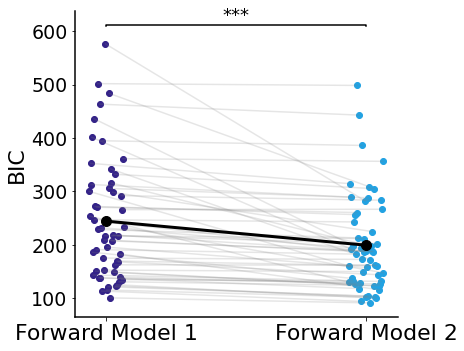

In [5]:
trials_len= len(data[data["sub"] == subjects[0]])
forward_df_simple = pd.read_csv("../results/forward_df.csv")
forward_df = pd.read_csv("../results/forward_df_complex.csv")
forward_df["bic"] = 6*np.log(trials_len) + 2*forward_df["LL"]
forward_df_simple["bic"] = 4*np.log(trials_len) + 2*forward_df_simple["LL"]
groups = ["Forward Model 1", "Forward Model 2"]

bic_df = merge_result_df([forward_df_simple, forward_df], groups, 400, subjects)
color_dict = {"Forward Model 1": "#332288", "Forward Model 2": "#22A2E2"}

plt.figure(figsize=(6.5, 5))
comparison_plot(
    bic_df,
    "bic",
    groups,
    "",
    [["Forward Model 1", "Forward Model 2"]],
    [610],
    [2],
    y_label="BIC",
    color_dict= color_dict
)

plt.tight_layout()

plt.savefig("../figs/Supp_fig10.png", dpi=400, bbox_inches = "tight")

# Supp Figure 11

In [ ]:
backward_params_ranges = [[0, 1],[0, 1],[0, 1], [0, 100], [1, 5], [0, 1]]
backward_res = fit_for_all_subjects_parallel(backward_params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
backward_df = make_df_after_fitting(backward_res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
backward_df["hbound"] = (5 - backward_df["lbound"]) * backward_df["bound_range"] + backward_df["lbound"]
backward_df.to_csv("../results/backward_complex_df.csv")

backward_params_ranges_unscaled = [[0, 1], [0, 1],[0, 1],[0, 100]]
backward_res_unscaled = fit_for_all_subjects_parallel(backward_params_ranges_unscaled, n_threads, n_fitting, subjects, data, fit_model_backward, False)
backward_df_unscaled = make_df_after_fitting(backward_res_unscaled, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
backward_df_unscaled["lbound"], backward_df_unscaled["hbound"] = 1, 5
backward_df_unscaled.to_csv("../results/backward_complex_df_unscaled.csv")

In [6]:
seed = 21

# Set the random seed
np.random.seed(seed)
random.seed(seed)

forward_df = pd.read_csv("../results/forward_df_complex.csv")
backward_df = pd.read_csv("../results/backward_complex_df.csv")
backward_df_unscaled = pd.read_csv("../results/backward_complex_df_unscaled.csv")

forward_simulation_df = simulate_with_params(forward_df, data, subjects, n= 100)
backward_simulation_df = simulate_with_params(backward_df, data, subjects, n= 100)
backward_unscaled_simulation_df = simulate_with_params(backward_df_unscaled, data, subjects, n= 100)

forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_unscaled_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
human_lv_df = data.rename(columns={"sub": "subject"})

In [9]:

# Calculate QSR, empirical accuracy (emp_acc), and empirical confidence judgment (emp_cj) 
lv_induction_data = data.copy()
emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "QSR": group_qsr(x),
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})

# Merge all necessary DataFrames together
backward_emp_df = averaged_dataframes[2].merge(emp_metrics_df, on="subject")

# Correctly align 'forward_cor' with subjects in 'backward_emp_df'
# This assumes 'forward_avg_df' is indexed by 'subject'; if not, ensure it is or adjust as necessary
forward_cor_aligned = backward_emp_df["subject"].map(averaged_dataframes[0].set_index("subject")["cor"])

# do the same for the backward_unscaled
backward_usncaled_cor_aligned = backward_emp_df["subject"].map(averaged_dataframes[3].set_index("subject")["cor"])


# Add new columns for MetaRL calculations and confidence bias
backward_emp_df["forward_cor"] = forward_cor_aligned
backward_emp_df["backward_unscaled_cor"] = backward_usncaled_cor_aligned
backward_emp_df["MetaRL"] = backward_emp_df["cor"] / backward_emp_df["forward_cor"]
backward_emp_df["MetaRL_unscaled"] = backward_emp_df["backward_unscaled_cor"] / backward_emp_df["forward_cor"]

# Rename columns as needed
backward_emp_df = backward_emp_df.rename(columns={"cor": "backward_cor"})

# Ensure the DataFrame is correctly formatted
backward_emp_df = backward_emp_df[['subject', 'backward_cor', 'QSR', 'emp_acc', 'emp_cj', 'forward_cor', 'MetaRL', 'MetaRL_unscaled']]

backward_with_params = pd.merge(backward_emp_df, forward_df, on =["subject"])

(p = 7.70e-03, r = 0.36,ci = [0.10,0.57])
(p = 9.55e-01, r = 0.01,ci = [-0.26,0.28])
(p = 4.85e-02, r = 0.27, ci = [0.00,0.50])


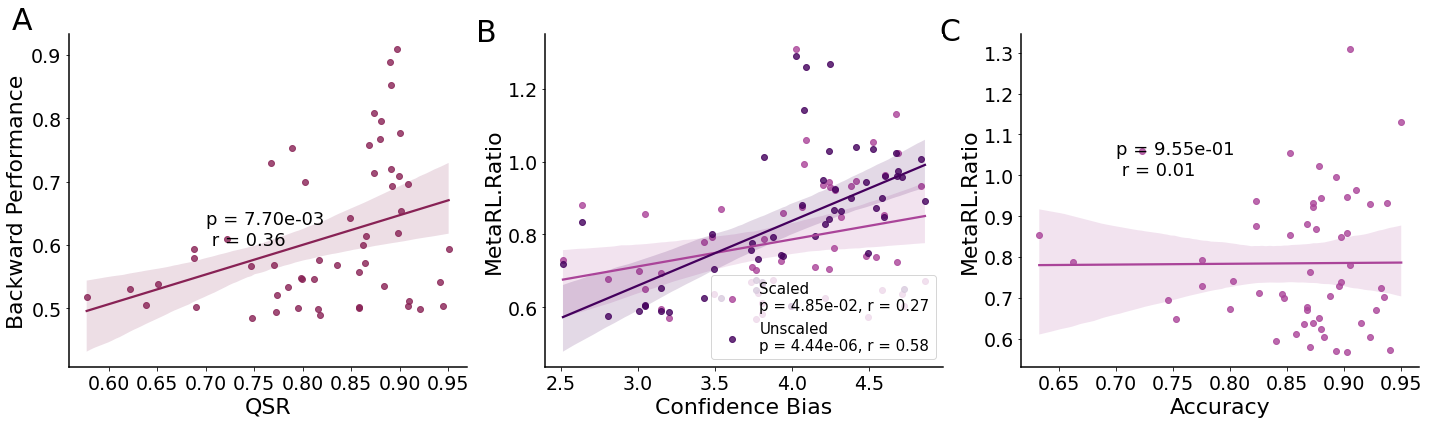

In [10]:
plt.figure(figsize=(20, 6))

color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}

plt.subplot(1,3,1)
plt.text(.5, .94, "A", fontsize=30)

plot_regression_df(backward_emp_df, "QSR", "backward_cor", color_dict["Backward"],0.7, .6, "QSR", "Backward Performance")


plt.subplot(1,3,3)

plt.text(.545, 1.33, "C", fontsize=30)

plot_regression_df(backward_emp_df, "emp_acc", "MetaRL", "#AA4499",0.7, 1, "Accuracy", "MetaRL.Ratio")


plt.subplot(1,3,2)

plt.text(1.95, 1.33, "B", fontsize=30)

res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

res2 = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

stat2, pval2= res2 
r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL", color="#AA4499", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="#44005D", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.legend(fontsize=15, loc = "lower right")


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/Supp_figure_11_A.png", dpi=400, bbox_inches = "tight")



(p = 9.89e-01, r = 0.00,ci = [-0.27,0.27])
(p = 9.73e-01, r = -0.00,ci = [-0.27,0.26])
(p = 5.03e-02, r = 0.27,ci = [-0.00,0.50])
(p = 9.82e-01, r = -0.00,ci = [-0.27,0.26])


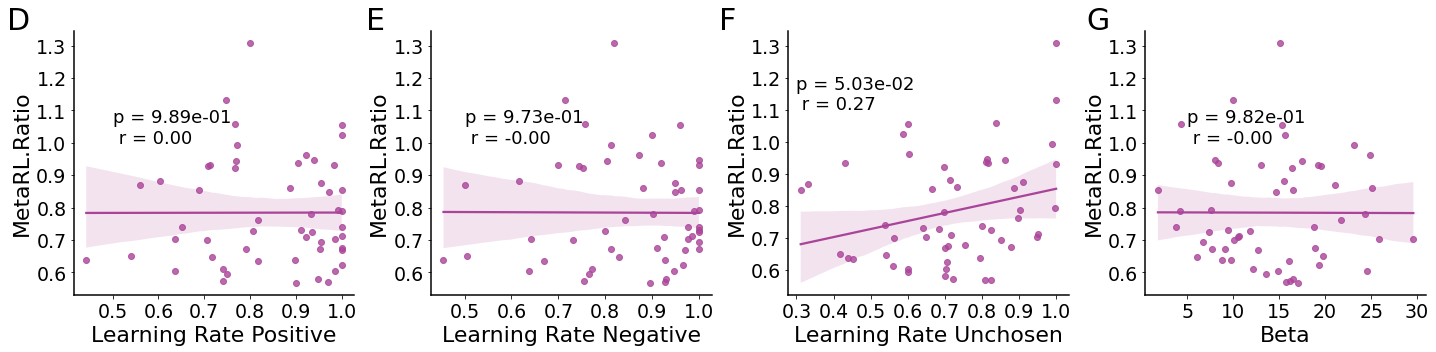

In [11]:
plt.figure(figsize=(20, 5))

color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}

plt.subplot(1,4,1)
plt.text(.27, 1.35, "D", fontsize=30)

plot_regression_df(backward_with_params, "alpha_pos", "MetaRL", "#AA4499",0.5, 1, "Learning Rate Positive", "MetaRL.Ratio")

plt.subplot(1,4,2)
plt.text(.29, 1.35, "E", fontsize=30)

plot_regression_df(backward_with_params, "alpha_neg", "MetaRL", "#AA4499",0.5, 1, "Learning Rate Negative", "MetaRL.Ratio")

plt.subplot(1,4,3)

plt.text(.09, 1.35, "F", fontsize=30)

plot_regression_df(backward_with_params, "alpha_unchosen", "MetaRL", "#AA4499",0.3, 1.1, "Learning Rate Unchosen", "MetaRL.Ratio")

plt.subplot(1,4,4)
plt.text(-6, 1.35, "G", fontsize=30)

plot_regression_df(backward_with_params, "beta", "MetaRL", "#AA4499",5, 1, "Beta", "MetaRL.Ratio")

plt.tight_layout()

plt.savefig("../figs/Supp_figure_11_B.png", dpi=400, bbox_inches = "tight")


plt.show()



# Supp Figure 12

In [12]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
hv_induction_data =  preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "lc1")
subjects = lv_induction_data["sub"].unique()
data_list = [lv_induction_data, hv_induction_data]
data_list_names = ["lv_induction", "hv_induction"]

In [35]:
n_fitting = 120
n_threads = 100

params_ranges = [[0, 1],[0, 1],[0, 1], [0, 100], [1, 5], [0, 1]]
forward_dfs = []

for data in data_list:
    forward_res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, data, forward_fitting, True)
    forward_df = make_df_after_fitting(forward_res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
    forward_df["hbound"] = (5 - forward_df["lbound"]) * forward_df["bound_range"] + forward_df["lbound"]
    forward_dfs.append(forward_df)
    
backward_dfs = []
for data in data_list:
    backward_res = fit_for_all_subjects_parallel(params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
    backward_df = make_df_after_fitting(backward_res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
    backward_df["hbound"] = (5 - backward_df["lbound"]) * backward_df["bound_range"] + backward_df["lbound"]
    backward_dfs.append(backward_df)

In [36]:
seed = 1
np.random.seed(seed)
random.seed(seed)

forward_simulation_dfs = []
backward_simulation_dfs = []
for forward_df, data in zip(forward_dfs, data_list):
    forward_simulation_df = simulate_with_params(forward_df, data, subjects , n = 100)
    forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    forward_simulation_dfs.append(forward_simulation_df)

for backward_df, data in zip(backward_dfs, data_list):
    backward_simulation_df = simulate_with_params(backward_df, data, subjects, n= 100)
    backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    backward_simulation_dfs.append(backward_simulation_df)

In [37]:
def calculate_avg_and_merge(simulation_dfs, data_list, merge_on="subject"):
    avg_dfs = []
    for sim_df, emp_data in zip(simulation_dfs,data_list):
        emp_data = emp_data.rename(columns = {"sub": "subject"})
        avg_df = sim_df.groupby(merge_on).agg(mean_reward=("reward", "mean"), 
                                               accuracy=("cor", "mean"), 
                                               mean_conf=("cj", "mean")).reset_index()
        
        emp_avg_df = emp_data.groupby(merge_on).agg(mean_reward_emp=("reward", "mean"), 
                                                    accuracy_emp=("cor", "mean"), 
                                                    mean_conf_emp=("cj", "mean")).reset_index()
                
        # Merge with empirical data and calculate difference or ratio
        merged_df = pd.merge(avg_df, emp_avg_df, on=merge_on)
        avg_dfs.append(merged_df)
        groups = ["lv_induction", "hv_induction"]
        df = merge_result_df(avg_dfs, groups, 200, subjects)
    return df

forward_avg_dfs = calculate_avg_and_merge(forward_simulation_dfs, data_list)
backward_avg_dfs = calculate_avg_and_merge(backward_simulation_dfs, data_list)

In [38]:
dfs = []
for backward_simulation_df, forward_simulation_df in zip(
    backward_simulation_dfs, forward_simulation_dfs
):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, forward_avg_df, on=["subject"])

    backward_avg_df["mrl_ratio"] = backward_avg_df["accuracy"] / backward_avg_df["cor"]
    dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction"]
mrl_df = merge_result_df(dfs, groups, 200, subjects)

In [39]:
backward_avg_dfs

,subject,mean_reward,accuracy,mean_conf,mean_reward_emp,accuracy_emp,mean_conf_emp,model,x_idx
0,45628,0.500617,0.502325,4.189384,0.589474,0.950000,4.676476,lv_induction,1
1,45640,0.513195,0.564600,3.446179,0.589456,0.940000,4.494590,lv_induction,2
2,45664,0.500507,0.500600,4.468472,0.556412,0.745000,3.148277,lv_induction,3
3,45682,0.511513,0.554325,3.431545,0.563513,0.825000,3.741547,lv_induction,4
4,45745,0.513496,0.565900,3.904187,0.588438,0.932500,4.684585,lv_induction,5
...,...,...,...,...,...,...,...,...,...
103,47431,0.510849,0.562080,2.353326,0.554269,0.746867,4.016351,hv_induction,250
104,47470,0.510168,0.561429,3.435743,0.559196,0.804511,4.399357,hv_induction,251
105,47737,0.505339,0.537820,4.592661,0.551392,0.739348,2.750151,hv_induction,252
106,47740,0.510127,0.562055,3.767974,0.557382,0.789474,4.383498,hv_induction,253


Statistics=330.0, p=0.000
Statistics=607.0, p=0.243


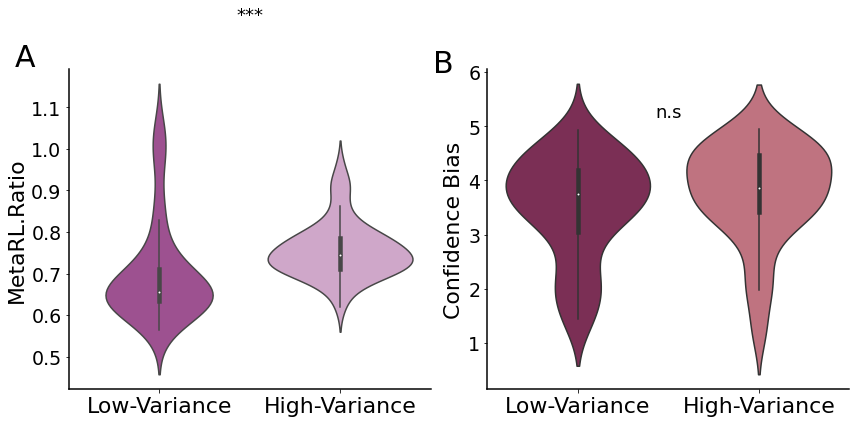

In [40]:
gr1 = "lv_induction"
gr2 = "hv_induction"

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
purple_colors = ["#AA4499", "#D6A0CD"]
red_colors = ["#882255", "#CC6677"]


plt.text(-.8, 1.2, "A", fontsize=30)

ax = seaborn.violinplot(data=mrl_df, x="model", y="mrl_ratio", palette= purple_colors)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Low-Variance", "High-Variance"])

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("", fontsize=25)


gr1_data = mrl_df.query("model=='{}'".format(gr1))
gr2_data = mrl_df.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["mrl_ratio"]), np.array(gr2_data["mrl_ratio"]))

print('Statistics={}, p={:.3f}'.format(stat, p))
symb = pval_symb(p) 

plt.text( .5, 1.3,symb , ha='center', va='bottom', fontsize=18)


plt.subplot(1,2,2)
plt.text(-.8, 6, "B", fontsize=30)

ax = seaborn.violinplot(backward_avg_dfs, x="model", y="mean_conf", palette= red_colors)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=22)
plt.yticks(fontsize=19)

ax.set_xticklabels(["Low-Variance", "High-Variance"])

plt.ylabel("Confidence Bias", fontsize=22)
plt.xlabel("", fontsize=25)


gr1_data = backward_avg_dfs.query("model=='{}'".format(gr1))
gr2_data = backward_avg_dfs.query("model=='{}'".format(gr2))

stat, p = scipy.stats.wilcoxon(np.array(gr1_data["mean_conf"]), np.array(gr2_data["mean_conf"]))

print('Statistics={}, p={:.3f}'.format(stat, p))
symb = pval_symb(p) 

plt.text( .5, 5.1,symb , ha='center', va='bottom', fontsize=18)


plt.tight_layout()
plt.savefig("../figs/Supp_fig12.png", dpi=400, bbox_inches='tight')

plt.show()
